# Incorporating an Initial Training Sample into a Project
Date: 2020-01-09 
Author: Jason Beach  
Categories: DataScience  
Tags: tag1, tag2 
<!--eofm-->

During a data science project, data is often provided in an incremental manner.  Some customer files are easier to obtain than others, such as when lengthy unarchiving processes are warranted.  To ensure no time is wasted, available data can be put to use with initial analyses and model training as a Training Sample.  The same data is incorporated with Training data when it is formally split into Training and Holdout sets.  Care must be taken to ensure there is not a systematic difference between the Training Sample and the greater Training Data.  While this arrangement is not ideal (it breaks the principal of data randomization), it is sometimes necessary in order to maintain a schedule.  This post simulates various different scenarios for this process and discusses the outcomes.

This will review the fundamental concepts and then demonstrate the general case, using the R statistical language.  We will use a uniform distribution sampling with a percentile cut-off to simulate a bernoulli random variable.  The sums of these variables creates a binomial distribution.

## Fundamentals of Randomness

The initial code that is sampling from a uniform distribution is easily implementable in most languages, so we will proceed with it.

In [15]:
options(repr.plot.width=4, repr.plot.height=3)

In [188]:
#bernoulli by sampling from uniform
rbern <- function(n,p){
    result = vector()
    for(i in 1:n){  
        if( runif(1,0,1) < p ){ 
            result[i] = 1
        }else{ 
            result[i] = 0
        }
        n=n-1;
    }
    return(result)
}
rand = rbern(10, .5)
print( t(rand))

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]    0    0    0    0    1    0    0    0    0     1


In [189]:
# bernoulli distribution using binom()
bern = rbinom(10, 1,.5)
t(bern)

0,1,1,0,1,1,1,0,1,0


In [190]:
# binomial distribution
rand = rbinom(1, 100, .5)
rand

[1] 51

## Simulation of Process

This is a simulation of the Training-Holdout set data splitting process.  We say there are 100 records total, and 5 of them are provided to us, and used in an initial analysis.  We assume a typical 80%-20%, Training-Holdout, split.  

In [119]:
SAMPLE_TNG = 5
TOTAL_RECORDS = 100
PCT_ORIG = 0.8

This will give us an expected 80 Training set records by using the expected value of the binomial pmf. 


\begin{align*}
k\binom{n}k=\frac{kn!}{k!(n-k)!}=\frac{n!}{(k-1)!(n-k)!}=\frac{n(n-1)!}{(k-1)!(n-k)!}=n\binom{n-1}{k-1}\;:
\end{align*}

\begin{align*}
\sum^n_{k=0}k\binom nkp^k(1-p)^{n-k}&=\sum_{k=0}^nn\binom{n-1}{k-1}p^k(1-p)^{n-k}\\
&=n\sum_{k=0}^n\binom{n-1}{k-1}p^k(1-p)^{n-k}\\
&=n\sum_{k=0}^{n-1}\binom{n-1}kp^{k+1}(1-p)^{n-k-1}\\
&=np\sum_{k=0}^{n-1}\binom{n-1}kp^k(1-p)^{n-k-1}\\
&=np\Big(p+(1-p)\Big)^{n-1}&&\text{using the binomial theorem}\\
&=np\;
\end{align*}

In [119]:
SPLIT_TNG = 80

We modify the simulation percentage so that it is corrected for the reduced number of training records.

\begin{align*}
TotalRecords + TrainingSample = TrainingData\\
Binomial(100,p) = TrainingData - Training Sample\\
np = TrainingData - Training Sample\\
p = (TrainingData - Training Sample) / n
\end{align*}

In [128]:
PCT_MOD = (SPLIT_TNG - SAMPLE_TNG) / TOTAL_RECORDS 
PCT_MOD

[1] 0.75

We will run the simulation 1,000 times to receive a nice distribution of results.

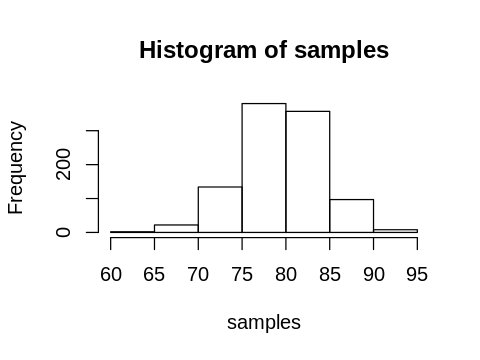

In [180]:
SAMPLE_TNG = 5
TOTAL_RECORDS = 100
PCT_ORIG = 0.8
SPLIT_TNG = 80
PCT_MOD = (SPLIT_TNG - SAMPLE_TNG) / TOTAL_RECORDS 

sim <- function(x){
    rand = rbern(x, PCT_MOD)
    tng = sum(rand) + SAMPLE_TNG
    return( tng )
    }

samples <- replicate(1000, sim(100))
hist(samples)

## Realistic Example

Let us add some more reasonable values for clarity.

[1] 42.6465


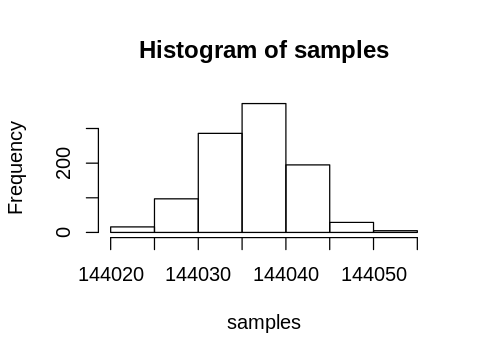

In [186]:
SAMPLE_TNG = 143994
TOTAL_RECORDS = (385 * 1000) + 490
PCT_ORIG = 0.8
SPLIT_TNG = TOTAL_RECORDS * PCT_ORIG
PCT_MOD = (SPLIT_TNG - SAMPLE_TNG) / TOTAL_RECORDS 

sim <- function(x){
    rand = rbern(x, PCT_MOD)
    tng = sum(rand) + SAMPLE_TNG
    return( tng )
    }

samples <- replicate(1000, sim(100))
print(PCT_MOD*100)
hist(samples)

## Possible Errors

In the real-world the problem was that the record Ids ("Stream ID" and "File Generation Date") were not unique, so there was a bad count of sample size.  This didn't adversely effect the splitting because the records were not sent to the Holdout set, and the quantity of miss-matched records was negligible.

However, it did cause error in the calculation of dataset sizes.  If the quantity was greater, then this could cause confusion, as well as inefficiently allocating the split datasets.  A small simulation of the error can provide insight to the incorrect results.

In [244]:
sim <- function(x, SAMPLE_TNG){
    rand = rbern(x, PCT_MOD)
    tng = sum(rand) + SAMPLE_TNG
    return( tng )
    }

ITER=100
SAMPLE_TNG_SEQ = seq(5, 15, length.out=ITER)
result = vector()
i = 1

for(sample_size in SAMPLE_TNG_SEQ){
    SAMPLE_TNG = sample_size
    TOTAL_RECORDS = 100
    PCT_ORIG = 0.8
    SPLIT_TNG = 80
    PCT_MOD = (SPLIT_TNG - SAMPLE_TNG) / TOTAL_RECORDS 

    tmp <- replicate(100, sim(100, SAMPLE_TNG))
    result[i] <- median(tmp)
    i=i+1
    }

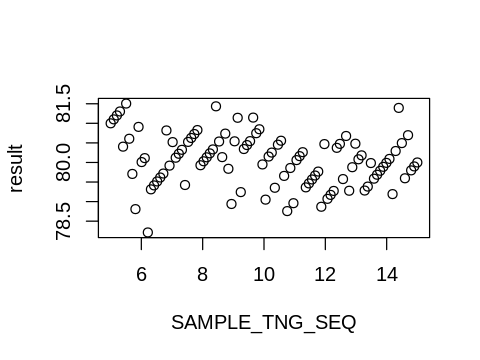

In [245]:
plot(result ~ SAMPLE_TNG_SEQ)

## Conclusion

Seemingly small problems can occur that may have large effects on a project schedule.  Working around those problems is imperative.  Some off-the-cuff calculations and a little stochastic simulation script, such as what you see here, may be just enough to keep a small problem from becoming a game-changer.